### 11/16 TCR Analysis in Python

### Import Libraries

In [3]:
import scanpy as sc
import scirpy as ir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import muon as mu

import random
random.seed(42)

### Create Gini Function

In [4]:
def gini(x):
    total = 0
    sorted_x = np.sort(x)
    for i, xi in enumerate(sorted_x[:-1], 1):
        total += np.sum(np.abs(xi - sorted_x[i:]))
    return total / (len(sorted_x)**2 * np.mean(sorted_x))

def pivot_table(v1, v2, N='N'):
    """
    Aggregates two identically indexed pd.Series into a table with amount of pairs (v1.x, v2.y) in a cell
    :param v1: pd.Series
    :param v2: pd.Series
    :return: pd.DataFrame pivot table
    """

    sub_df = pd.DataFrame({'V1':v1,
                           'V2':v2})
    sub_df['N'] = 1

    return pd.pivot_table(data=sub_df, columns='V1',
                          index='V2', values='N', aggfunc=sum).fillna(0).astype(int)

### Read h5ad File

In [5]:
tcr_data = sc.read_h5ad("/Users/johnmorris/Desktop/Comp_Bio_MS_Weill_Cornell/Summer_2023/Betel Lab/Betel:Iliev Candida Project/Candida_Migratory_TCR_Project/py/so_vdj.h5ad")

### Simple QC

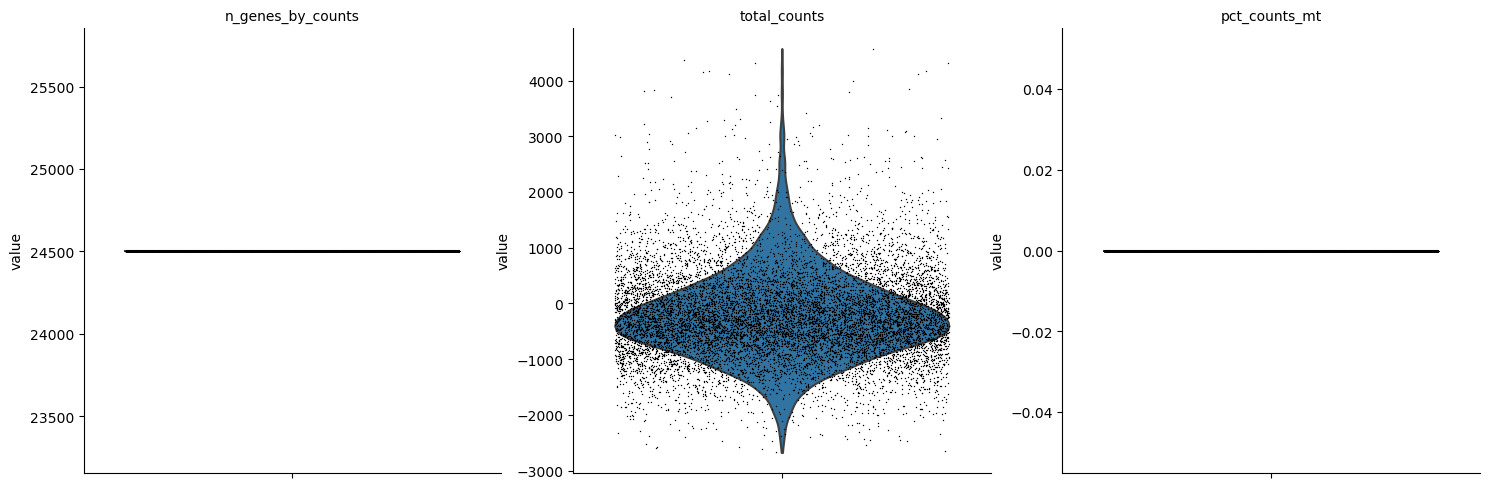

In [6]:
tcr_data.var['mt'] = tcr_data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
tcr_data.var['ribo'] = tcr_data.var_names.str.startswith(("RPS","RPL")) # ribosomal genes
tcr_data.var['hb'] = tcr_data.var_names.str.contains(("^HB[^(P)]")) # hemoglobin genes

sc.pp.calculate_qc_metrics(tcr_data, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
# plot QC

sc.pl.violin(tcr_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Metadata

In [7]:
# Check out observations to map which mouse is which
# tcr_data.obs.iloc[:, :15]

mouse_mapping = {
    0:'Non-infected Male',
    1:'Infected Male',
    2:'Infected Female',
}

tcr_data.obs['Mousenew'] = tcr_data.obs['Mouse'].map(mouse_mapping)

organ_mapping = {
    0:'Colon',
    1:'Lung',
    2:'mLns',
}

tcr_data.obs['Organnew'] = tcr_data.obs['Organ'].map(organ_mapping)


# Also make RNA clusters categorical
tcr_data.obs['RNA_clusters'] = pd.Categorical(tcr_data.obs['RNA_clusters'])

In [8]:
tcr_data.obs['Mousenew']
tcr_data.obs['Organnew']
#tcr_data.obs.iloc[:, :15]

AAACCTGAGAGGTTAT-1     Lung
AAACCTGAGATGAGAG-1    Colon
AAACCTGAGATTACCC-1     Lung
AAACCTGAGCATGGCA-1    Colon
AAACCTGAGCCTTGAT-1     Lung
                      ...  
TTTGTCATCAACACAC-1     Lung
TTTGTCATCCCGGATG-1     mLns
TTTGTCATCGTTACGA-1    Colon
TTTGTCATCGTTGCCT-1     Lung
TTTGTCATCTCCAACC-1     Lung
Name: Organnew, Length: 11830, dtype: object

### Checking Clustering

/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


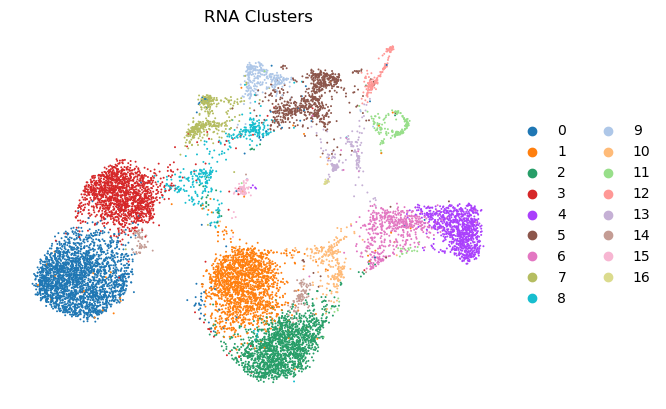

/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


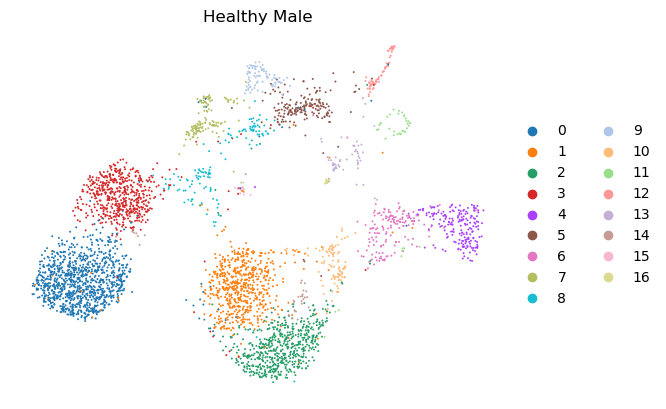

/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


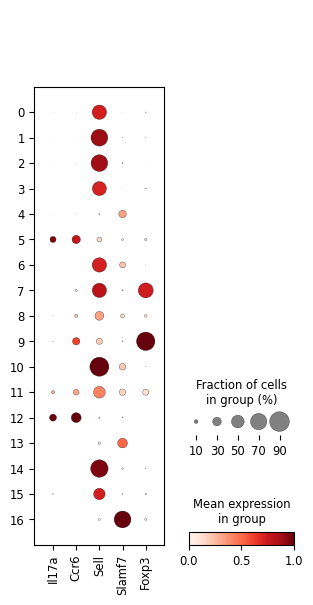

In [9]:
#tcr_data

sc.pl.umap(tcr_data, color=['RNA_clusters'],ncols=1,
           size=8,
           outline_color=('white','white'),
           title='RNA Clusters', frameon=False)

sc.pl.umap(tcr_data[tcr_data.obs.Mousenew=="Non-infected Male"], color=['RNA_clusters'],ncols=1,
           size=8,
           outline_color=('white','white'),
           title='Healthy Male', frameon=False)

markers2 = ['Il17a', 'Ccr6', 'Sell', 'Slamf7', 'Foxp3']

sc.pl.dotplot(tcr_data, var_names=markers2, groupby='RNA_clusters',standard_scale='var', use_raw=True)

### TCR

In [46]:
#adata = sc.read_10x_h5("example_data/liao-2019-covid19/GSM4339772_C144_filtered_feature_bc_matrix.h5")

tcr2 = ir.io.read_10x_vdj("/Users/johnmorris/Desktop/Comp_Bio_MS_Weill_Cornell/Summer_2023/Betel Lab/Betel:Iliev Candida Project/Candida_Migratory_TCR_Project/Data/TCR_data/filtered_contig_annotations.csv")
mdata = mu.MuData({"gex": tcr_data, "airr": tcr2})
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


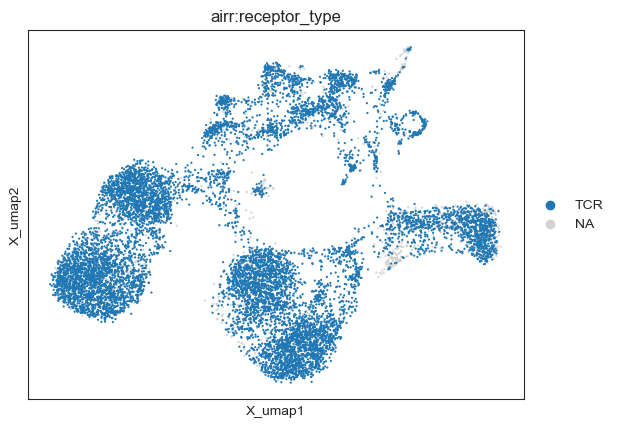

/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


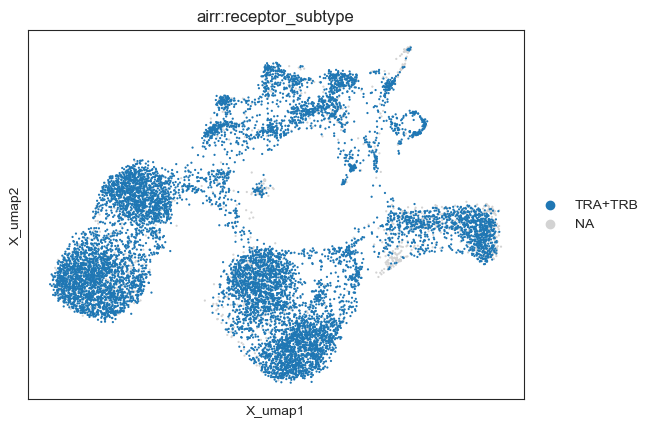

/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


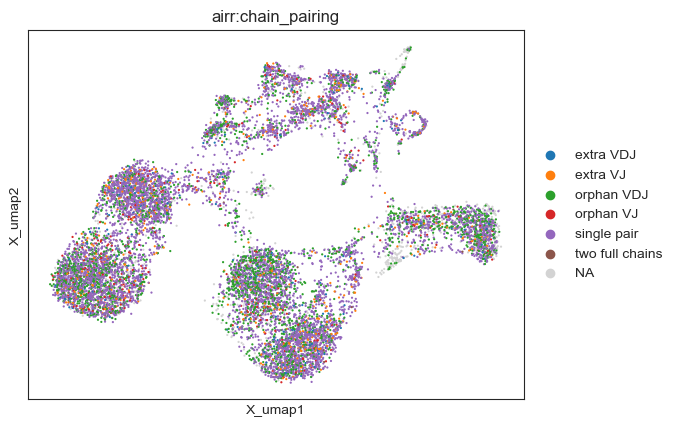

In [47]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"])
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_subtype"])
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:chain_pairing"])

In [51]:
# Have to select only cells with both clone_id and cell_barcode (We want only cells with TCR and RNA-seq)

#mdata.obs.columns
#mdata
mdata2 = mdata[(mdata.obs['airr:clone_id'].notna())]
mdata3 = mdata2[(mdata2.obs['gex:cell_barcode'].notna())]
mdata3

View of MuData object with n_obs × n_vars = 9858 × 55487
  2 modalities
    gex:	9858 x 55487
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_barcode', 'nCount_HTO', 'nCount_ADT', 'nFeature_ADT', 'HTO_classification.simplified', 'sample_name', 'RNA_clusters', 'Protein_clusters', 'Infection', 'Sex', 'Organ', 'Mouse', 'SingleR.indiv.labels.main', 'SingleR.indiv.labels.fine', 'SingleR.cluster.labels.main', 'SingleR.cluster.labels.fine', 'percent.mt', 'SingleR.cluster.labels.gross', 'pseudotime', 'TCR', 'chains', 'n_chains', 'cdr3', 'cdr3_nt', 'cdr3_length', 'cdr3_nt_length', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'reads', 'umis', 'productive', 'full_length', 'paired', 'clonotype_id', 'RNA_new', 'n_cells.x', 'cdr3_freq.x', 'cdr3_pct.x', 'cdr3_shared.x', 'cdr3_grp.x', 'temp', 'cdr3_simpson_diversity.x', 'cdr3_simpson_stderr', 'cdr3_shannon_diversity.x', 'cdr3_shannon_stderr', 'cdr3_pielou evenness_diversity.x', 'cdr3_pielou evenness_stderr', 'MDS_1.x', 'MDS_2.x', 'cdr3_simpson_diversity.y', 'cdr3_shannon_diversity.y', 'cdr3_pielou evenness_diversity.y', 'cdr3_simpson_diversity.x.x', 'cdr3_shannon_diversity.x.x', 'cdr3_pielou evenness_diversity.x.x', 'cdr3_simpson_diversity.y.y', 'cdr3_shannon_diversity.y.y', 'cdr3_pielou evenness_diversity.y.y', 'MDS_1.y', 'MDS_2.y', 'cdr3_simpson_diversity.x.x.x', 'cdr3_shannon_diversity.x.x.x', 'cdr3_pielou evenness_diversity.x.x.x', 'temp2', 'cdr3_simpson_diversity.y.y.y', 'cdr3_shannon_diversity.y.y.y', 'cdr3_pielou evenness_diversity.y.y.y', 'cdr3_simpson_diversity.x.x.x.x', 'cdr3_shannon_diversity.x.x.x.x', 'cdr3_pielou evenness_diversity.x.x.x.x', 'cdr3_simpson_diversity.y.y.y.y', 'cdr3_shannon_diversity.y.y.y.y', 'cdr3_pielou evenness_diversity.y.y.y.y', 'n_cells.y', 'cdr3_freq.y', 'cdr3_pct.y', 'cdr3_shared.y', 'cdr3_grp.y', 'cdr3_simpson_diversity', 'cdr3_shannon_diversity', 'cdr3_pielou evenness_diversity', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'Mousenew', 'Organnew'
      var:	'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'RNA_clusters_colors', 'airr:receptor_type_colors', 'airr:receptor_subtype_colors', 'airr:chain_pairing_colors'
      obsm:	'X_umap', 'X_umap_adt', 'X_umap_rna'
    airr:	9858 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
      uns:	'scirpy_version', 'chain_indices', 'ir_dist_cdr3_hamming', 'ir_dist_nt_identity', 'clone_id'
      obsm:	'airr', 'chain_indices'

In [52]:
ir.tl.chain_qc(mdata)
ir.pp.ir_dist(
    mdata3,
    metric='hamming',
    sequence="cdr3",
    n_jobs=7,
    cutoff=5,
) # computes distances between CDR3 or amino acid sequences

ir.tl.define_clonotypes(mdata3, receptor_arms="VDJ", dual_ir="primary_only") 

100%|██████████| 19701/19701 [00:20<00:00, 956.41it/s] 
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scirpy/ir_dist/__init__.py:226: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  params.adata.uns[key_added] = result
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 9599/9599 [00:16<00:00, 591.52it/s]
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scirpy/util/__init__.py:183: ImplicitModificationWarning: Trying to modify attribute

In [53]:
mdata3.obs

,gex:orig.ident,gex:nCount_RNA,gex:nFeature_RNA,gex:cell_barcode,gex:nCount_HTO,gex:nCount_ADT,gex:nFeature_ADT,gex:HTO_classification.simplified,gex:sample_name,gex:RNA_clusters,...,gex:pct_counts_ribo,gex:total_counts_hb,gex:pct_counts_hb,gex:Mousenew,gex:Organnew,airr:receptor_type,airr:receptor_subtype,airr:chain_pairing,airr:clone_id,airr:clone_id_size
AAACCTGAGAGGTTAT-1,0,7139.0,2592,AAACCTGAGAGGTTAT-1,670.0,4541.0,124,HT5,1,10,...,0.0,0.0,0.0,Non-infected Male,Lung,TCR,TRA+TRB,single pair,0,1
AAACCTGAGATGAGAG-1,0,2819.0,1321,AAACCTGAGATGAGAG-1,995.0,2455.0,123,HT2,0,0,...,-0.0,0.0,-0.0,Non-infected Male,Colon,TCR,TRA+TRB,single pair,1,1
AAACCTGAGATTACCC-1,0,3188.0,1394,AAACCTGAGATTACCC-1,511.0,3397.0,121,HT7,7,1,...,-0.0,0.0,-0.0,Infected Female,Lung,TCR,TRA+TRB,orphan VDJ,2,1
AAACCTGAGCGATCCC-1,0,2636.0,1222,AAACCTGAGCGATCCC-1,1680.0,3340.0,119,HT2,0,6,...,-0.0,0.0,-0.0,Non-infected Male,Colon,TCR,TRA+TRB,extra VJ,3,1
AAACCTGAGCGCTTAT-1,0,2885.0,1108,AAACCTGAGCGCTTAT-1,629.0,2235.0,114,HT2,0,2,...,-0.0,0.0,-0.0,Non-infected Male,Colon,TCR,TRA+TRB,orphan VDJ,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAACACAC-1,0,3378.0,1550,TTTGTCATCAACACAC-1,107.0,2159.0,116,HT5,1,0,...,-0.0,0.0,-0.0,Non-infected Male,Lung,TCR,TRA+TRB,extra VJ,9594,1
TTTGTCATCCCGGATG-1,0,2996.0,1429,TTTGTCATCCCGGATG-1,701.0,2343.0,124,HT10,8,3,...,-0.0,0.0,-0.0,Infected Female,mLns,TCR,TRA+TRB,single pair,9595,1
TTTGTCATCGTTACGA-1,0,771.0,519,TTTGTCATCGTTACGA-1,378.0,967.0,103,HT4,6,4,...,-0.0,0.0,-0.0,Infected Female,Colon,TCR,TRA+TRB,single pair,9596,1
TTTGTCATCGTTGCCT-1,0,4145.0,1658,TTTGTCATCGTTGCCT-1,394.0,2877.0,124,HT6,4,1,...,-0.0,0.0,-0.0,Infected Male,Lung,TCR,TRA+TRB,orphan VDJ,9597,1


/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


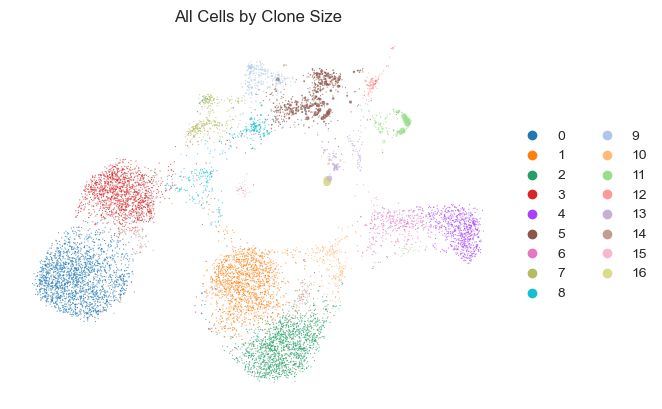

In [54]:
sc.pl.umap(mdata3['gex'],
           color=['RNA_clusters'],
           size=3*mdata3.obs['airr:clone_id_size'],
       #     save='_clone_size_healthy.pdf',
           add_outline=True,
           outline_width=(0.02,0.01),
           outline_color=('white','white'),
            title='All Cells by Clone Size',
           frameon=False)

In [17]:
# This tells me how many were duplicated and how many are not
#len(~mdata3.obs.duplicated(['airr:clone_id']))
#~mdata3.obs.duplicated(['airr:clone_id']).value_counts()
#len(mdata3.obs)


/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


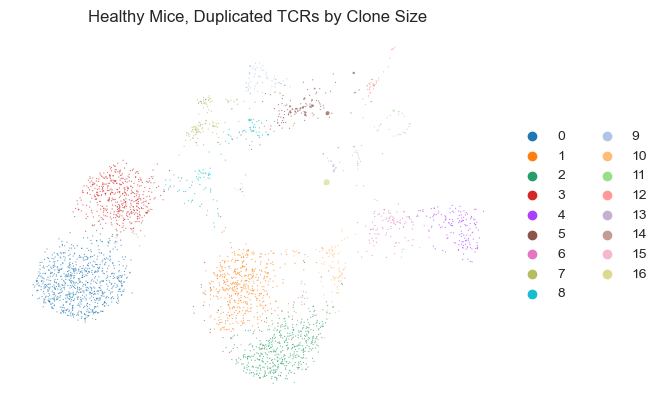

/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


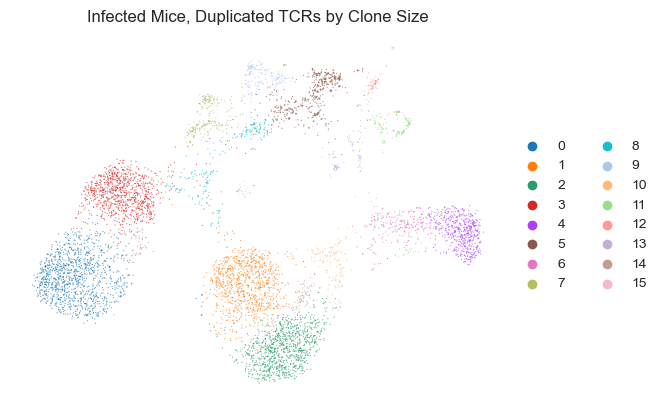

In [55]:
sc.pl.umap(mdata3['gex'][(mdata3.obs['gex:Infection']==0)&(~mdata3.obs.duplicated(['airr:clone_id']))],
           color=['RNA_clusters'],
           size=3*mdata3[(mdata3.obs['gex:Infection']==0)&(~mdata3.obs.duplicated(['airr:clone_id']))].obs['airr:clone_id_size'],
       #     save='_clone_size_healthy_duplicated.pdf',
           add_outline=True,
           outline_width=(0.02,0.01),
           outline_color=('white','white'),
            title='Healthy Mice, Duplicated TCRs by Clone Size',
           frameon=False)

sc.pl.umap(mdata3['gex'][(mdata3.obs['gex:Infection']==1)&(~mdata3.obs.duplicated(['airr:clone_id']))],
           color=['RNA_clusters'],
           size=3*mdata3[(mdata3.obs['gex:Infection']==1)&(~mdata3.obs.duplicated(['airr:clone_id']))].obs['airr:clone_id_size'],
       #     save='_clone_size_infected_duplicated.pdf',
           add_outline=True,
           outline_width=(0.02,0.01),
           outline_color=('white','white'),
            title='Infected Mice, Duplicated TCRs by Clone Size',
           frameon=False)

### Gini Index

In [56]:
mdata3.obs.columns
mdata3.obs['N'] = 1
gb = mdata3.obs.groupby(['gex:Mousenew','gex:Organ','gex:RNA_clusters','airr:clone_id']).aggregate('count')['N'].reset_index()
gb['gex:Mousenew'].unique()

['Infected Female', 'Infected Male', 'Non-infected Male']
Categories (3, object): ['Infected Female', 'Infected Male', 'Non-infected Male']

In [57]:
Gini_all = []
for mouse in gb['gex:Mousenew'].unique():
    gb_mouse = gb[(gb['gex:Mousenew']==mouse)]
    clone_counts = pd.pivot_table(data=gb_mouse, values='N', index='airr:clone_id', columns='gex:RNA_clusters', aggfunc='sum')
    #clone_counts = clone_counts.fillna(0)
    gini_mouse=clone_counts.apply(lambda col: gini(col[col>0])).to_frame(name='Gini index')
    gini_mouse['Mouse'] = mouse
    Gini_all.append(gini_mouse)
    

Gini_all = pd.concat(Gini_all).reset_index()

/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
Gini_all[1:5]

,gex:RNA_clusters,Gini index,Mouse
1,1,0.002070,Infected Female
2,2,0.003781,Infected Female
3,3,0.000000,Infected Female
4,4,0.006269,Infected Female


Text(0.5, 1.0, 'Gini index')

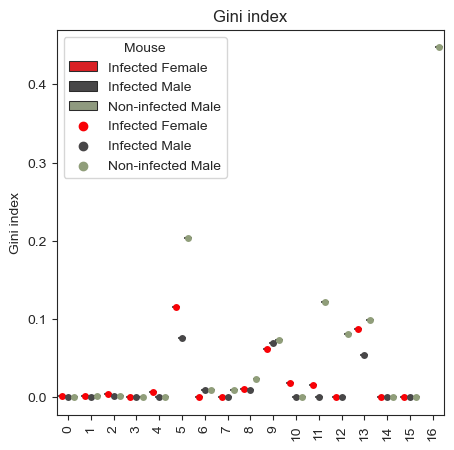

In [58]:

mouse_colors = {'Infected Female':'#F80106', 'Infected Male':'#484748', 'Non-infected Male':'#909e7a'}

fig,ax = plt.subplots(figsize=(5,5))
sns.set_style('ticks')
sns.boxplot(data=Gini_all, x='gex:RNA_clusters', y='Gini index', hue='Mouse', palette = mouse_colors)
sns.swarmplot(data=Gini_all, x='gex:RNA_clusters', y='Gini index', hue='Mouse', palette = mouse_colors, dodge=True)
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Gini index')

#plt.tight_layout()
#plt.savefig('figures/Gini_clusters.pdf')

### Gini Index with Downsample

### Migratory Clonotypes across Organ

In [59]:
grouped_data = mdata3.obs.groupby(['airr:clone_id', 'gex:Mousenew', 'gex:Organnew'])
#grouped_data.head

#duplicate_cells
#mdata3.obs.columns

grouped_df = pd.DataFrame(grouped_data.size().reset_index(name='Number of Cells'))

print(grouped_df)


      airr:clone_id       gex:Mousenew gex:Organnew  Number of Cells
0                 0    Infected Female        Colon                0
1                 0    Infected Female         Lung                0
2                 0    Infected Female         mLns                0
3                 0      Infected Male        Colon                0
4                 0      Infected Male         Lung                0
...             ...                ...          ...              ...
86386           999      Infected Male         Lung                0
86387           999      Infected Male         mLns                0
86388           999  Non-infected Male        Colon                0
86389           999  Non-infected Male         Lung                0
86390           999  Non-infected Male         mLns                1

[86391 rows x 4 columns]


In [60]:
filtered_df = grouped_df[grouped_df['Number of Cells'] > 0]

# Group by 'airr:clone_id' and 'gex:Mousenew'
grouped_clone_mouse = filtered_df.groupby(['airr:clone_id', 'gex:Mousenew'])

# Filter for groups with multiple 'gex:Organnew'
multiple_organs = grouped_clone_mouse.filter(lambda x: len(x['gex:Organnew'].unique()) > 1)

# Display the result
print(multiple_organs)

      airr:clone_id       gex:Mousenew gex:Organnew  Number of Cells
2481           1245  Non-infected Male        Colon                1
2482           1245  Non-infected Male         Lung                1
3271           1324      Infected Male         Lung                1
3272           1324      Infected Male         mLns                1
3723            137  Non-infected Male        Colon                1
...             ...                ...          ...              ...
55516           655      Infected Male         Lung                1
57120           671  Non-infected Male        Colon                1
57122           671  Non-infected Male         mLns                3
65653          7563  Non-infected Male         Lung                1
65654          7563  Non-infected Male         mLns                1

[75 rows x 4 columns]


<Figure size 1400x800 with 0 Axes>

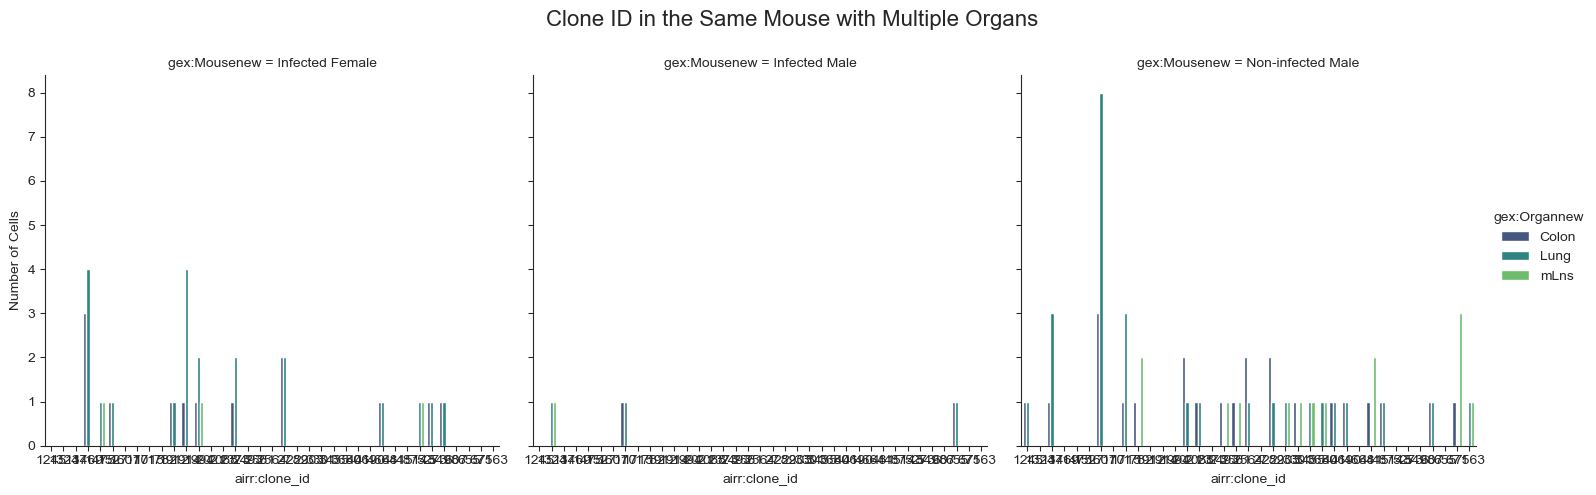

In [61]:
plt.figure(figsize=(14, 8))
sns.catplot(
    x='airr:clone_id', 
    y='Number of Cells', 
    hue='gex:Organnew', 
    col='gex:Mousenew', 
    data=multiple_organs, 
    kind='bar',
    palette='viridis'
)
plt.subplots_adjust(top=0.85)
plt.suptitle('Clone ID in the Same Mouse with Multiple Organs', fontsize=16)
plt.show()

### Proliferating Clonotypes

In [82]:
#mdata3.obs.columns
mdata_dup = mdata3[(mdata3.obs['airr:clone_id_size'] > 1)]


mdata_dup.obs = mdata_dup.obs.sort_values(by='airr:clone_id_size')

#mdata_dup.obs
#mdata_dup.obs[mdata_dup.obs['airr:clone_id'] == 2932]

# If we want to include clones with only 1 cell
#no_male_obs = mdata3[mdata3.obs['gex:Mousenew'] == "Non-infected Male"]
#ca_male_obs = mdata3[mdata3.obs['gex:Mousenew'] == "Infected Male"]
#ca_female_obs = mdata3[mdata3.obs['gex:Mousenew'] == "Infected Female"]

no_male_obs = mdata_dup[mdata_dup.obs['gex:Mousenew'] == "Non-infected Male"]
ca_male_obs = mdata_dup[mdata_dup.obs['gex:Mousenew'] == "Infected Male"]
ca_female_obs = mdata_dup[mdata_dup.obs['gex:Mousenew'] == "Infected Female"]

/Users/johnmorris/anaconda3/envs/candida_project/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [90]:
clone_data_no_male = no_male_obs.obs[['airr:clone_id', 'airr:clone_id_size']].copy()
clone_data_ca_male = ca_male_obs.obs[['airr:clone_id', 'airr:clone_id_size']].copy()
clone_data_ca_female = ca_female_obs.obs[['airr:clone_id', 'airr:clone_id_size']].copy()

# Drop duplicate rows to keep only unique clone_id values
clone_data_no_male = clone_data_no_male.drop_duplicates()
clone_data_ca_male = clone_data_ca_male.drop_duplicates()
clone_data_ca_female = clone_data_ca_female.drop_duplicates()

# Optionally, you can reset the index if needed
clone_data_no_male.reset_index(drop=True, inplace=True)
clone_data_ca_male.reset_index(drop=True, inplace=True)
clone_data_ca_female.reset_index(drop=True, inplace=True)

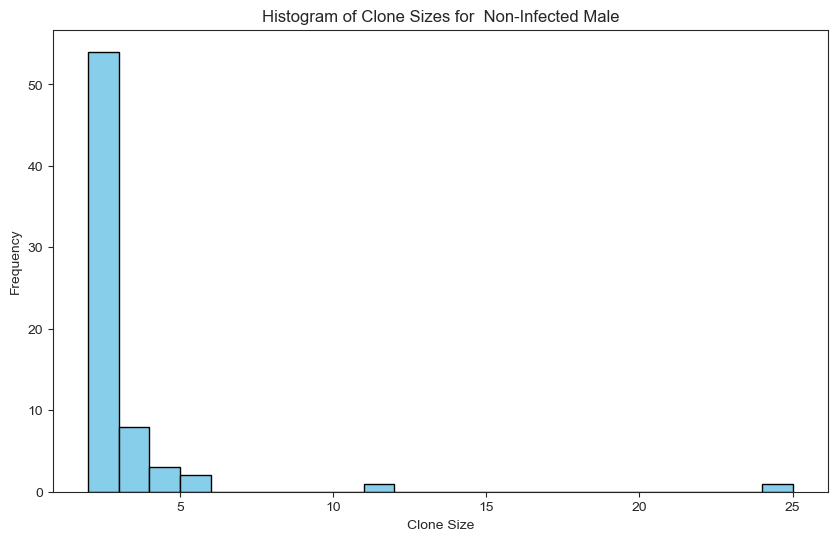

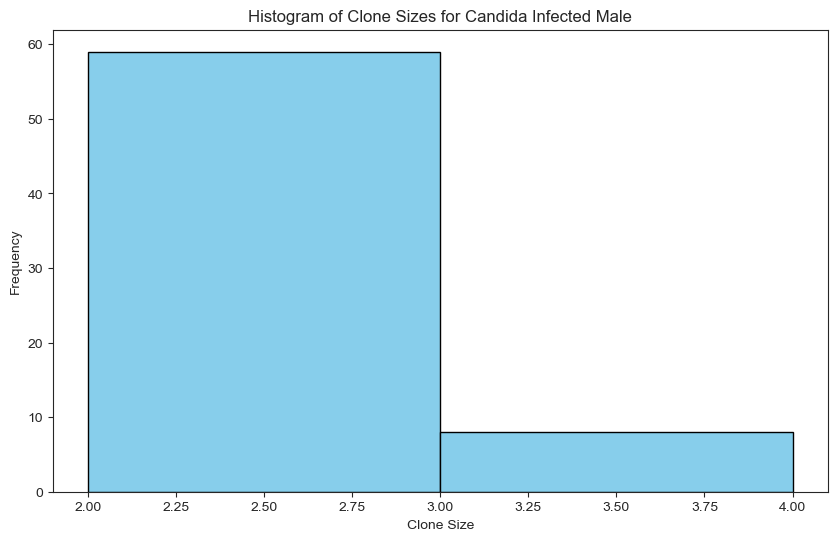

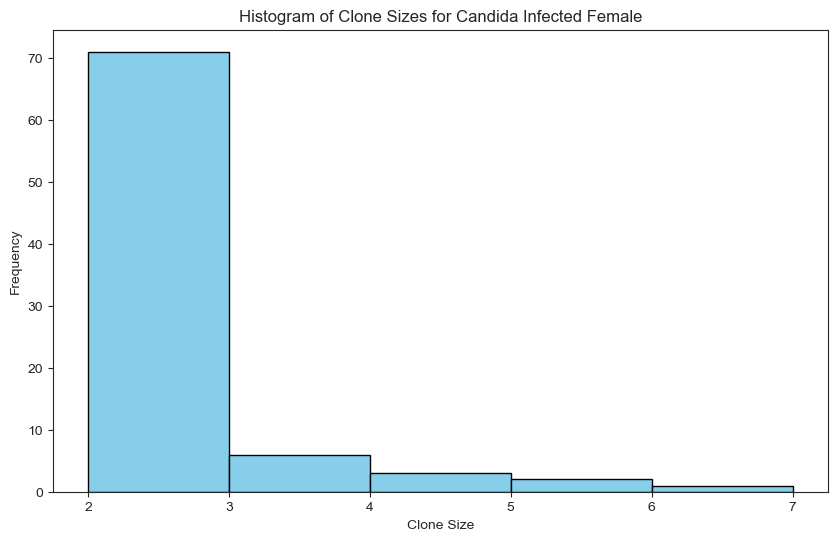

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(clone_data_no_male['airr:clone_id_size'], bins=range(min(clone_data_no_male['airr:clone_id_size']), max(clone_data_no_male['airr:clone_id_size']) + 1), color='skyblue', edgecolor='black')
plt.xlabel('Clone Size')
plt.ylabel('Frequency')
plt.title('Histogram of Clone Sizes for  Non-Infected Male')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(clone_data_ca_male['airr:clone_id_size'], bins=range(min(clone_data_ca_male['airr:clone_id_size']), max(clone_data_ca_male['airr:clone_id_size']) + 1), color='skyblue', edgecolor='black')
plt.xlabel('Clone Size')
plt.ylabel('Frequency')
plt.title('Histogram of Clone Sizes for Candida Infected Male')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(clone_data_ca_female['airr:clone_id_size'], bins=range(min(clone_data_ca_female['airr:clone_id_size']), max(clone_data_ca_female['airr:clone_id_size']) + 1), color='skyblue', edgecolor='black')
plt.xlabel('Clone Size')
plt.ylabel('Frequency')
plt.title('Histogram of Clone Sizes for Candida Infected Female')
plt.show()